In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
import csv
import os
pd.set_option('display.max_rows', None)
import datetime as dt

In [4]:
url = "https://data.nashville.gov/resource/6v6w-hpcw.json?$limit=140100"
crash_data = requests.get(url).json()

In [5]:
crash_data_df = pd.DataFrame(crash_data)
crash_data_df.tail()

,accident_number,date_and_time,number_of_motor_vehicles,number_of_injuries,number_of_fatalities,hit_and_run,reporting_officer,collision_type,collision_type_description,weather,...,rpa,precinct,lat,long,mapped_location,:@computed_region_wvby_4s8j,:@computed_region_3aw5_2wv7,:@computed_region_p6sk_2acq,:@computed_region_gxvr_9jxz,property_damage
140095,20180004714,2018-01-02T14:55:00.000,2.0000,1.0000,0.0000,False,256414,11,Front to Rear,21,...,84020,SOUTH,36.1034,-86.7148,"{'type': 'Point', 'coordinates': [-86.7148, 36...",1,1,9,3,NaN
140096,20180004701,2018-01-02T14:40:00.000,3.0000,0.0000,0.0000,False,716886,11,Front to Rear,21,...,8705,SOUTH,36.0810,-86.7158,"{'type': 'Point', 'coordinates': [-86.7158, 36...",1,1,12,3,NaN
140097,20180004698,2018-01-02T00:00:00.000,2.0000,0.0000,0.0000,True,197070,98,OTHER,21,...,4489,NORTH,36.1887,-86.8141,"{'type': 'Point', 'coordinates': [-86.8141, 36...",1,1,2,51,NaN
140098,20180004655,2018-01-02T14:35:00.000,2.0000,0.0000,0.0000,False,226095,3,REAR-TO-REAR,21,...,8835,SOUTH,36.1155,-86.6951,"{'type': 'Point', 'coordinates': [-86.6951, 36...",1,1,6,22,NaN
140099,20180004641,2018-01-02T14:05:00.000,2.0000,0.0000,0.0000,True,137982,11,Front to Rear,21,...,9201,HERMIT,36.1694,-86.6799,"{'type': 'Point', 'coordinates': [-86.6799, 36...",1,1,8,38,NaN


In [6]:
clean_crash_df = pd.DataFrame(crash_data_df, columns=["accident_number", "date_and_time", "number_of_motor_vehicles",
                                                      "number_of_injuries", "number_of_fatalities", "weather_description", "zip", "precinct"])
clean_crash_df = clean_crash_df.loc[clean_crash_df["accident_number"] < "20230000000"]
clean_crash_df.head()

,accident_number,date_and_time,number_of_motor_vehicles,number_of_injuries,number_of_fatalities,weather_description,zip,precinct
13612,20220663726,2022-12-31T23:50:00.000,2,0,0,FOG,37013,SOUTH
13613,20220663675,2022-12-21T21:39:00.000,2,0,0,CLEAR,37204,MIDTOW
13614,20220663674,2022-12-31T23:20:00.000,1,0,0,CLEAR,37207,NORTH
13615,20220663673,2022-12-31T15:20:00.000,2,0,0,CLEAR,37013,SOUTH
13616,20220663596,2022-12-31T22:35:00.000,2,1,0,CLEAR,37211,SOUTH


In [7]:
total_crashes = len(clean_crash_df)
total_crashes

126488

In [8]:
clean_crash_df['year'] = pd.DatetimeIndex(clean_crash_df['date_and_time']).year
clean_crash_df['month'] = pd.DatetimeIndex(clean_crash_df['date_and_time']).month
clean_crash_df['weekday'] = pd.DatetimeIndex(clean_crash_df['date_and_time']).weekday
cleaner_crash_df = pd.DataFrame(clean_crash_df, columns=["date_and_time", "year", "month", "weekday", "number_of_motor_vehicles", "zip", "precinct",
                                                      "number_of_injuries", "number_of_fatalities", "weather_description"])
cleaner_crash_df.head()

,date_and_time,year,month,weekday,number_of_motor_vehicles,zip,precinct,number_of_injuries,number_of_fatalities,weather_description
13612,2022-12-31T23:50:00.000,2022,12,5,2,37013,SOUTH,0,0,FOG
13613,2022-12-21T21:39:00.000,2022,12,2,2,37204,MIDTOW,0,0,CLEAR
13614,2022-12-31T23:20:00.000,2022,12,5,1,37207,NORTH,0,0,CLEAR
13615,2022-12-31T15:20:00.000,2022,12,5,2,37013,SOUTH,0,0,CLEAR
13616,2022-12-31T22:35:00.000,2022,12,5,2,37211,SOUTH,1,0,CLEAR


In [9]:
cleaner_crash_df["weekday"] = cleaner_crash_df["weekday"].replace([1],'Tuesday')
cleaner_crash_df["weekday"] = cleaner_crash_df["weekday"].replace([2],'Wednesday')
cleaner_crash_df["weekday"] = cleaner_crash_df["weekday"].replace([3],'Thursday')
cleaner_crash_df["weekday"] = cleaner_crash_df["weekday"].replace([4],'Friday')
cleaner_crash_df["weekday"] = cleaner_crash_df["weekday"].replace([5],'Saturday')
cleaner_crash_df["weekday"] = cleaner_crash_df["weekday"].replace([6],'Sunday')
cleaner_crash_df["weekday"] = cleaner_crash_df["weekday"].replace([0],'Monday')

cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([1],'Jan')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([2],'Feb')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([3],'Mar')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([4],'Apr')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([5],'May')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([6],'Jun')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([7],'Jul')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([8],'Aug')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([9],'Sep')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([10],'Oct')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([11],'Nov')
cleaner_crash_df["month"] = cleaner_crash_df["month"].replace([12],'Dec')


cleaner_crash_df.head()

,date_and_time,year,month,weekday,number_of_motor_vehicles,zip,precinct,number_of_injuries,number_of_fatalities,weather_description
13612,2022-12-31T23:50:00.000,2022,Dec,Saturday,2,37013,SOUTH,0,0,FOG
13613,2022-12-21T21:39:00.000,2022,Dec,Wednesday,2,37204,MIDTOW,0,0,CLEAR
13614,2022-12-31T23:20:00.000,2022,Dec,Saturday,1,37207,NORTH,0,0,CLEAR
13615,2022-12-31T15:20:00.000,2022,Dec,Saturday,2,37013,SOUTH,0,0,CLEAR
13616,2022-12-31T22:35:00.000,2022,Dec,Saturday,2,37211,SOUTH,1,0,CLEAR


In [36]:
cleaner_crash_df = cleaner_crash_df.loc[cleaner_crash_df["year"] > 2017]
cleanest_crash_df = cleaner_crash_df.loc[cleaner_crash_df["year"] < 2023]
cleanest_crash_df.head()

,date_and_time,year,month,weekday,number_of_motor_vehicles,zip,precinct,number_of_injuries,number_of_fatalities,weather_description
13612,2022-12-31T23:50:00.000,2022,Dec,Saturday,2,37013,SOUTH,0,0,FOG
13613,2022-12-21T21:39:00.000,2022,Dec,Wednesday,2,37204,MIDTOW,0,0,CLEAR
13614,2022-12-31T23:20:00.000,2022,Dec,Saturday,1,37207,NORTH,0,0,CLEAR
13615,2022-12-31T15:20:00.000,2022,Dec,Saturday,2,37013,SOUTH,0,0,CLEAR
13616,2022-12-31T22:35:00.000,2022,Dec,Saturday,2,37211,SOUTH,1,0,CLEAR


In [37]:
crash_per_year = cleanest_crash_df["year"].value_counts()
crash_per_year

year
2019    34591
2018    34371
2020    21025
2021    18777
2022    17719
Name: count, dtype: int64

Text(0, 0.5, 'Number of Crashes')

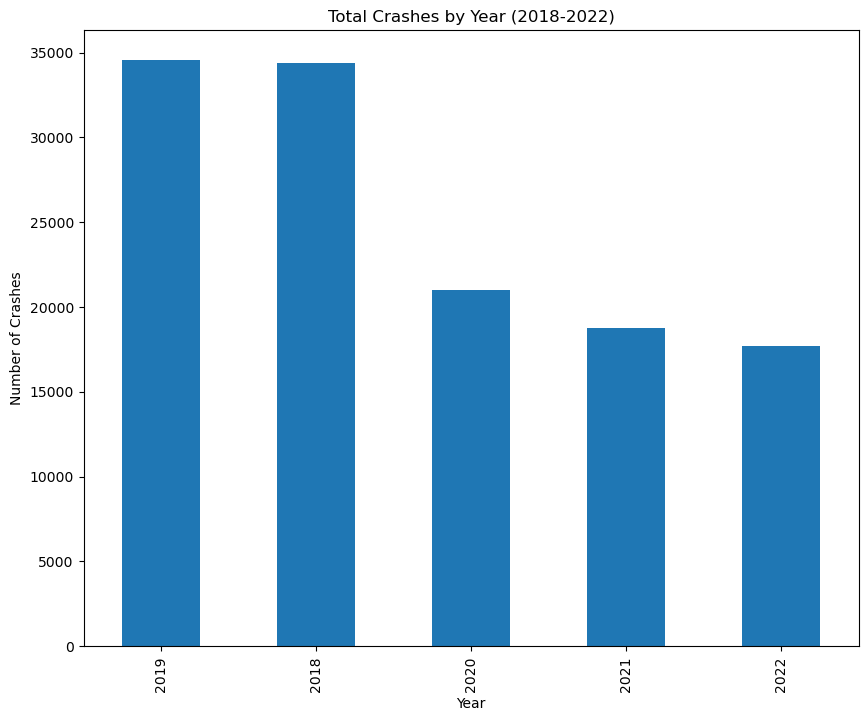

In [55]:
crash_per_year.plot(kind="bar",figsize=(10, 8))
plt.title("Total Crashes by Year (2018-2022)")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")

In [38]:
crash_by_month = cleanest_crash_df["month"].value_counts()
crash_by_month

month
Oct    11699
Mar    10984
May    10947
Jan    10894
Feb    10864
Nov    10679
Aug    10592
Apr    10303
Dec    10019
Sep     9982
Jun     9925
Jul     9595
Name: count, dtype: int64

Text(0, 0.5, 'Number of Crashes')

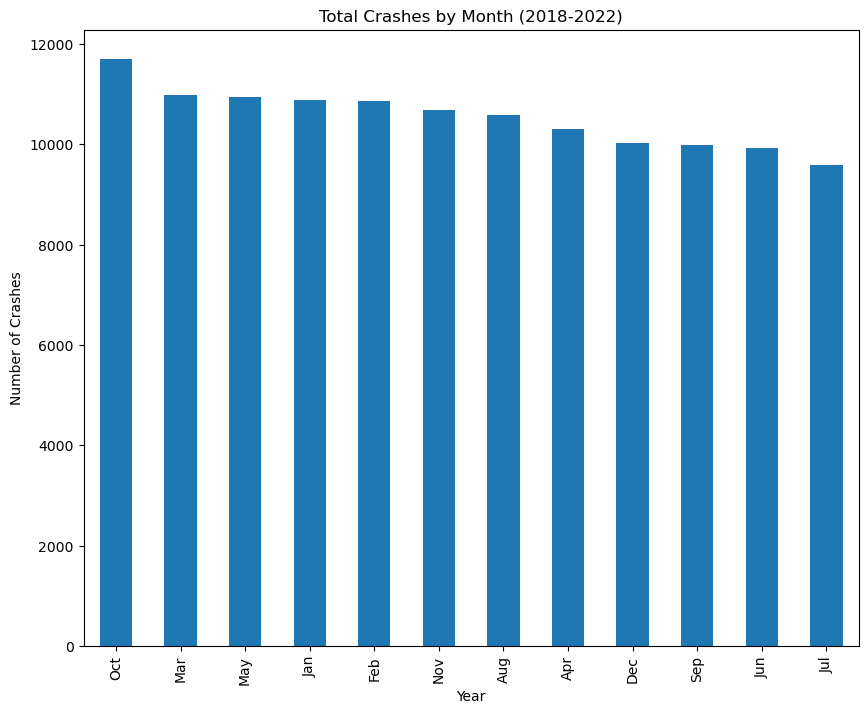

In [56]:
crash_by_month.plot(kind="bar",figsize=(10, 8))
plt.title("Total Crashes by Month (2018-2022)")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")

In [39]:
crash_by_weekday = cleanest_crash_df["weekday"].value_counts()
crash_weekday_count = pd.DataFrame(crash_by_weekday)
crash_weekday_count

,count
weekday,
Friday,21420
Thursday,19675
Wednesday,19157
Tuesday,18699
Monday,17878
Saturday,16312
Sunday,13342


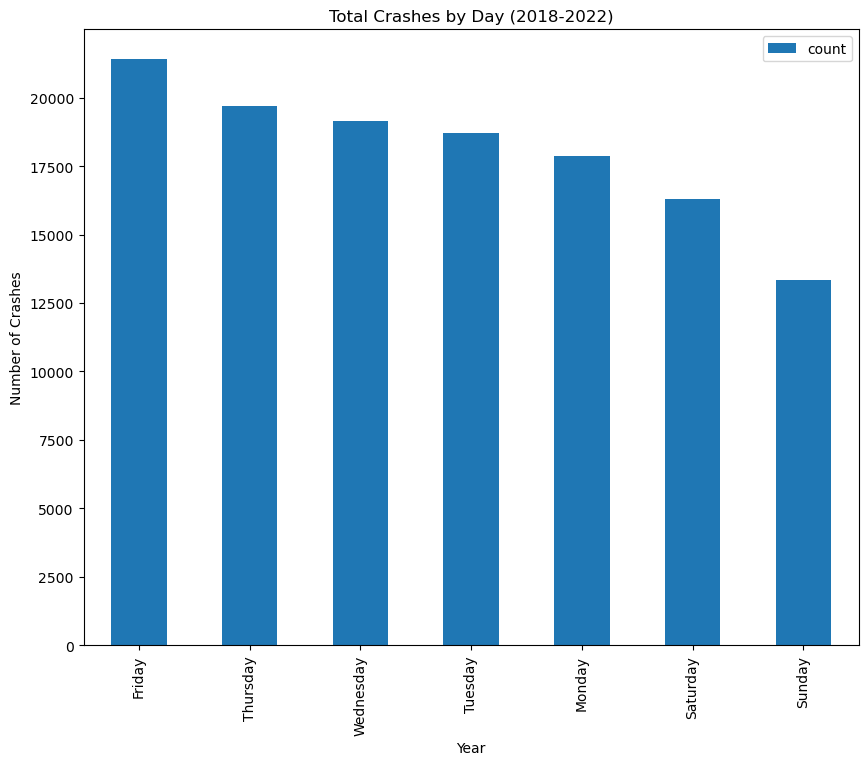

In [40]:
crash_weekday_count.plot(kind="bar",figsize=(10, 8))
plt.title("Total Crashes by Day (2018-2022)")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")
plt.savefig('Total_Crashes_by_Day')

In [41]:
crash_by_timeofyear = pd.DataFrame(cleanest_crash_df.groupby("year")["month"].value_counts())
crash_by_timeofyear

count
year month       
2018 Oct     3243
     Aug     3095
     May     2996
     Mar     2968
     Nov     2959
     Dec     2870
     Apr     2833
     Sep     2822
     Jan     2742
     Jun     2697
     Jul     2575
     Feb     2571
2019 Oct     3284
     Apr     3120
     May     3049
     Nov     3042
     Aug     2920
     Mar     2904
     Jun     2869
     Feb     2763
     Sep     2735
     Jul     2676
     Dec     2619
     Jan     2610
2020 Jan     2727
     Feb     2663
     Mar     2049
     Oct     1767
     May     1764
     Nov     1583
     Aug     1530
     Dec     1515
     Sep     1453
     Jun     1384
     Jul     1380
     Apr     1210
2021 Oct     1800
     Nov     1655
     Aug     1618
     Jul     1605
     May     1595
     Mar     1556
     Apr     1555
     Sep     1530
     Jun     1510
     Dec     1494
     Feb     1450
     Jan     1409
2022 Oct     1605
     Apr     1585
     May     1543
     Dec     1521
     Mar     1507
     Jun     1465
     Sep     1442
     Nov     1440
     Aug     1429
     Feb     1417
     Jan     1406
     Jul     1359

<Axes: xlabel='year,month'>

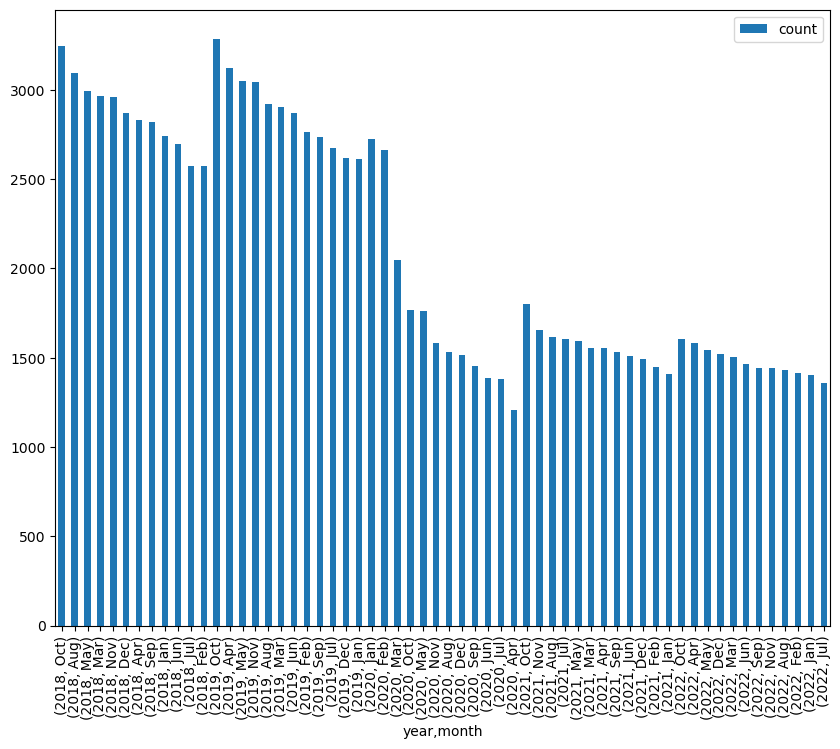

In [42]:
crash_by_timeofyear.plot(kind="bar",figsize=(10, 8))

In [43]:
crash_by_day_and_year = pd.DataFrame(cleanest_crash_df.groupby("year")["weekday"].value_counts())
crash_by_day_and_year

count
year weekday         
2018 Friday      6027
     Thursday    5499
     Tuesday     5259
     Wednesday   5139
     Monday      4926
     Saturday    4204
     Sunday      3317
2019 Friday      5835
     Wednesday   5394
     Thursday    5284
     Tuesday     5192
     Monday      5054
     Saturday    4372
     Sunday      3460
2020 Friday      3571
     Thursday    3285
     Wednesday   3177
     Tuesday     3076
     Monday      2863
     Saturday    2752
     Sunday      2301
2021 Friday      3082
     Thursday    2932
     Wednesday   2745
     Monday      2603
     Tuesday     2584
     Saturday    2542
     Sunday      2289
2022 Friday      2905
     Wednesday   2702
     Thursday    2675
     Tuesday     2588
     Saturday    2442
     Monday      2432
     Sunday      1975

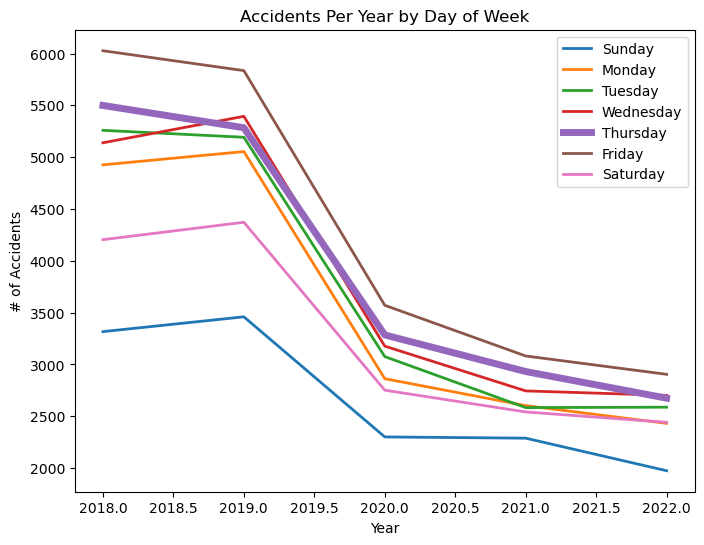

In [54]:
x1 = [2018, 2019, 2020, 2021, 2022]
y1 = [3317, 3460, 2301, 2289, 1975]
y2 = [4926, 5054, 2863, 2603, 2432]
y3 = [5259, 5192, 3076, 2584, 2588]
y4 = [5139, 5394, 3177, 2745, 2702]
y5 = [5499, 5284, 3285, 2932, 2675]
y6 = [6027, 5835, 3571, 3082, 2905]
y7 = [4204, 4372, 2752, 2542, 2442]
plt.figure(figsize=(8,6))
plt.plot(x1, y1, linewidth=2, label="Sunday")
plt.plot(x1, y2, linewidth=2, label="Monday")
plt.plot(x1, y3, linewidth=2, label="Tuesday")
plt.plot(x1, y4, linewidth=2, label="Wednesday")
plt.plot(x1, y5, linewidth=5, label="Thursday")
plt.plot(x1, y6, linewidth=2, label="Friday")
plt.plot(x1, y7, linewidth=2, label="Saturday")
plt.title("Accidents Per Year by Day of Week")
plt.xlabel("Year")
plt.ylabel("# of Accidents")
plt.legend()
plt.savefig('Accidents_Per_Year_by_Day')
plt.show()